# Logistic Regression Modeling using SVD

In [81]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import explained_variance_score, accuracy_score, roc_auc_score, roc_curve, confusion_matrix, plot_confusion_matrix
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
np.random.seed(42)

Importing the data to use for modeling

In [3]:
word_df = pd.read_pickle('../data/word_df.gzde', compression = 'gzip')

In [5]:
svd_df = pd.read_pickle('../data/svd_df.gzde', compression = 'gzip')

In [6]:
target = pd.read_pickle('../data/target.gzde', compression = 'gzip')

Splitting up the data into train and test sets, stratifying on my target variable, since after all the cleaning, the 2 subreddits were not completely balanced (roughly 48% from ADHD and 52% from Anxiety).

In [7]:
X_train, X_test, y_train, y_test = train_test_split(svd_df, target, stratify=target, random_state=42)

In [8]:
lr_svd = LogisticRegression(penalty='none', max_iter=1000)

In [9]:
%%time
lr_svd.fit(X_train, y_train)

CPU times: user 5.6 s, sys: 37.1 ms, total: 5.64 s
Wall time: 956 ms


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='none',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [10]:
lr_svd.score(X_train, y_train)

0.8677390527256479

In [11]:
lr_svd.score(X_test, y_test)

0.855674709562109

Surprisingly, logistic regression performed well. On the training set, the accuracy rate was 87% and on the test set it was 86%. Now let's compare it with a Random Forests Classifier. If you're unfamiliar with Random Forests, the name comes from its relation to Decision Trees, which is essentially a classifier based on splitting up the data using many if-statements. Random Forests classification uses many (i.e. bagged) decision trees, bootstraps them (i.e. sampling with replacement), and modifies the tree learning algorithm so that at each split in the learning process, a random subset of features (in this case words) is used. 

---

# Random Forest Modeling using SVD

In [12]:
params = {'min_samples_split': [2, 4, 8, 15],
          'min_samples_leaf': [1, 3, 5, 10]}

I set the hyperparameters above for the minimum data points required for a decision tree split and the creation of a new leaf. I tried out many combinations of values, but the differences in the scores was no more than 5%.

In [13]:
gs_svd = GridSearchCV(RandomForestClassifier(n_estimators=100), 
                  param_grid=params, return_train_score=True, cv=5, n_jobs=10)

In [14]:
%%time
gs_svd.fit(X_train, y_train)

CPU times: user 34.7 s, sys: 276 ms, total: 35 s
Wall time: 7min 52s


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [15]:
gs_svd.score(X_train, y_train)

0.9865951742627346

In [16]:
gs_svd.score(X_test, y_test)

0.8223860589812333

As expected, our Random Forest model overfit on the training set, getting an accuracy of over 98%, but did slightly worse on the test set than the logistic regression model, getting only 82%.

In [17]:
gs_svd.best_params_

{'min_samples_leaf': 5, 'min_samples_split': 8}

The above accuracy numbers were generated from the GridSearch algorithm choosing the best combination of 5 minimum samples per leaf and 8 minimum samples per split as the optimal hyperparameters.

Here I'm grabbing the most important components from the best estimator in the model above and graphing it to visualize the amount of variance explained by each component. 

In [38]:
feat_importance = pd.DataFrame(gs_svd.best_estimator_.feature_importances_, svd_df.columns, columns=['importance'])

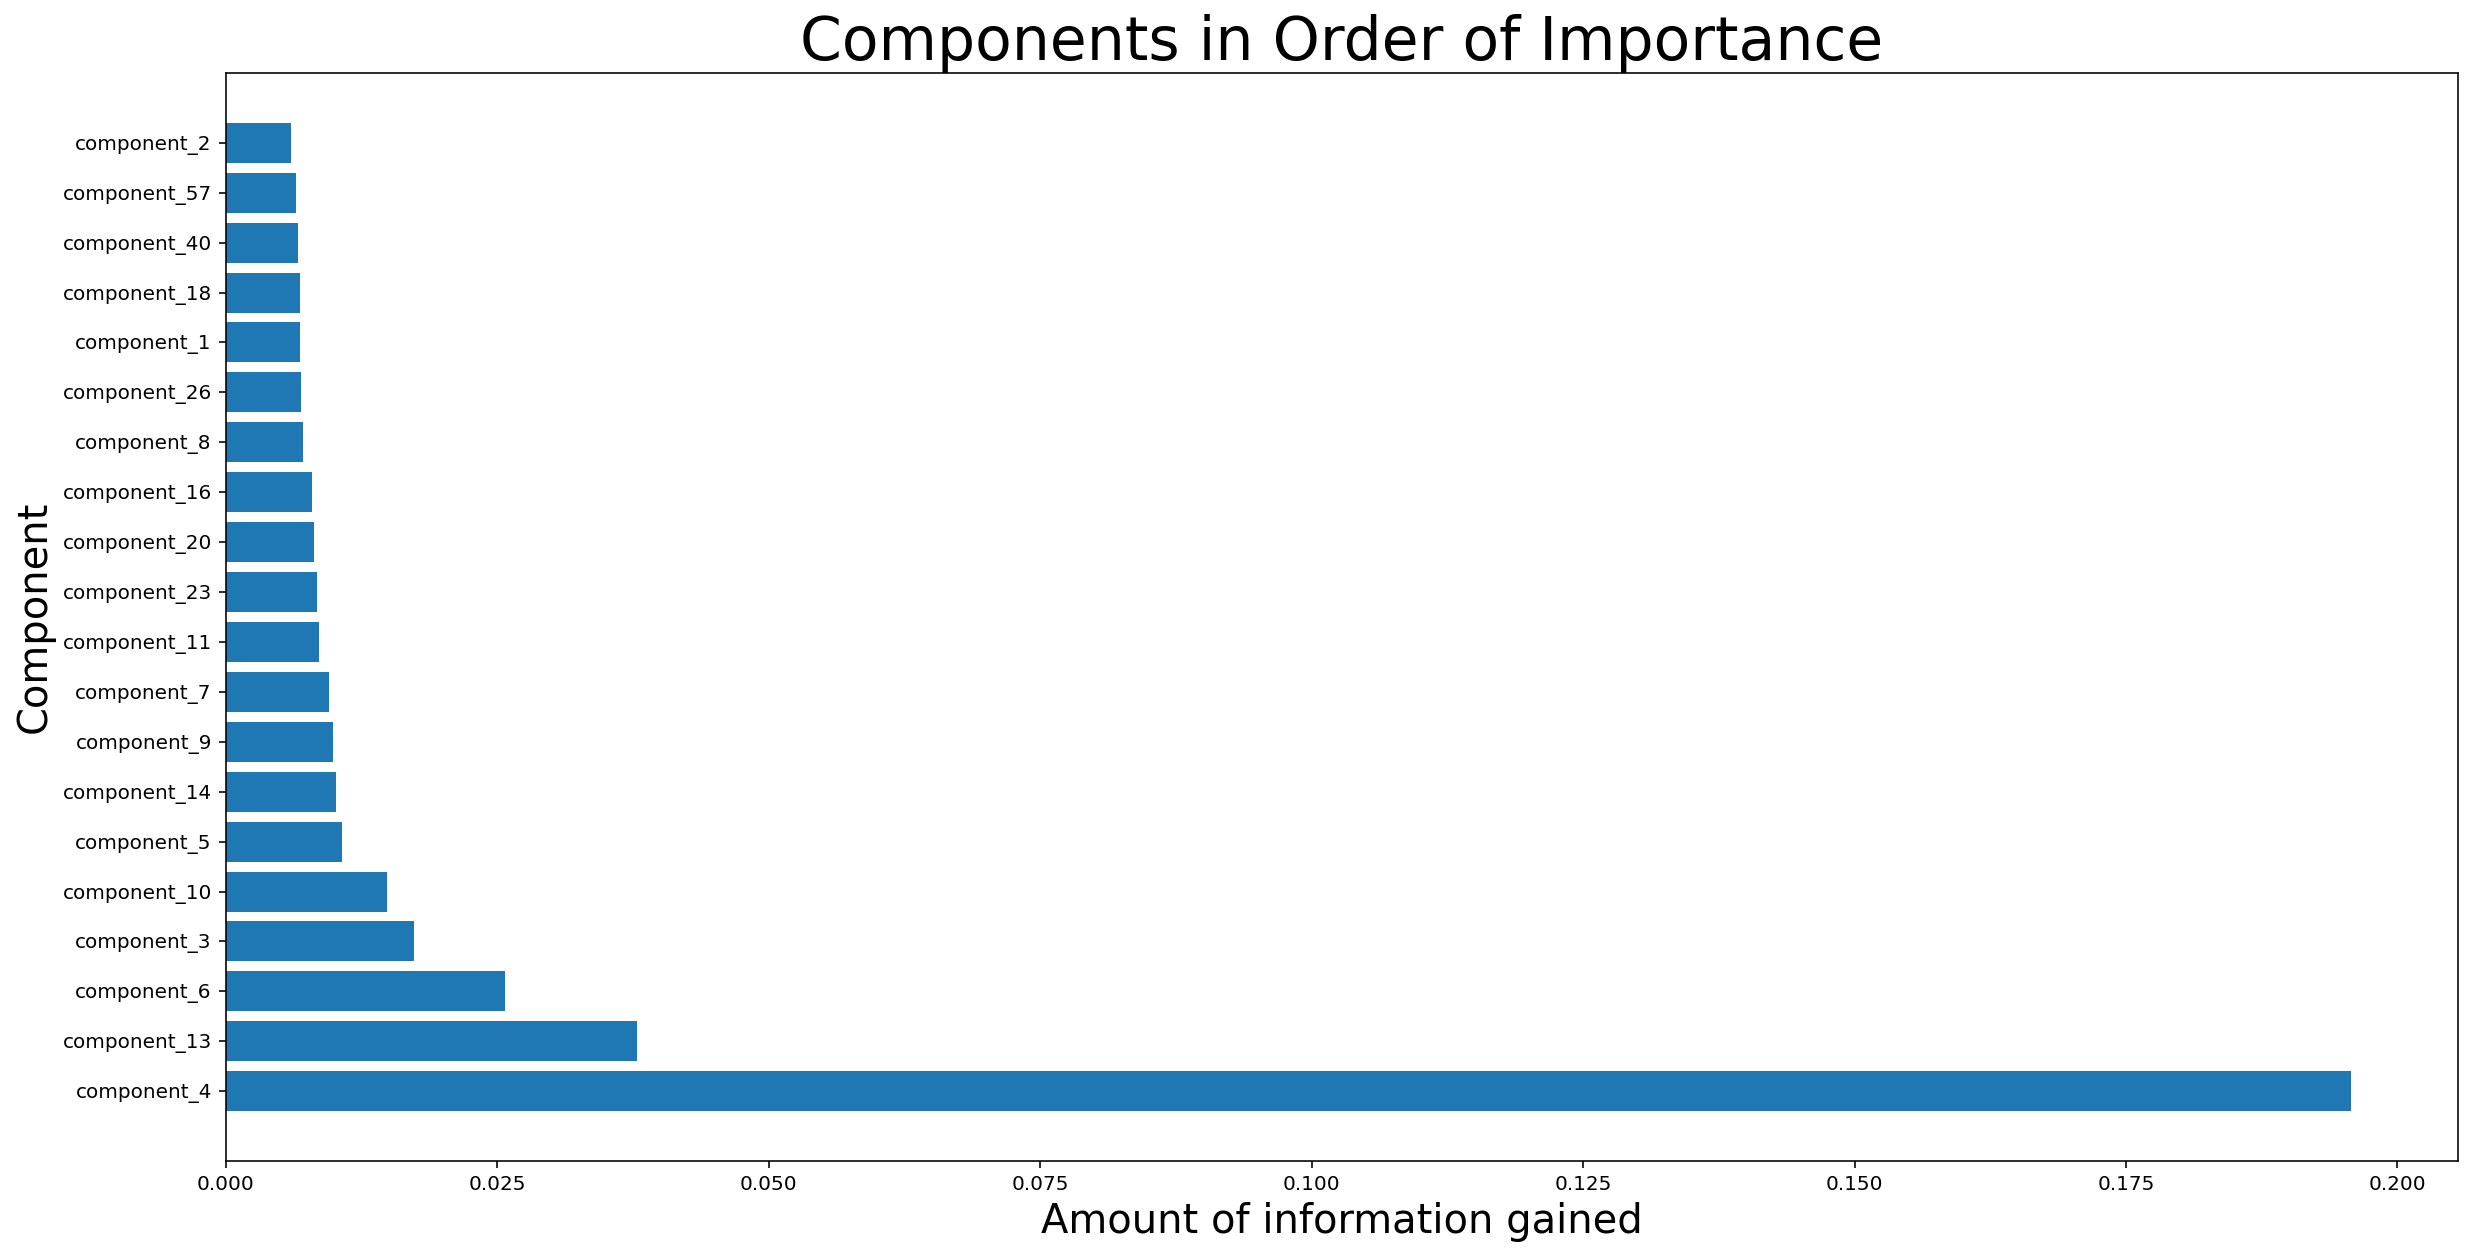

In [39]:
plt.figure(figsize=(20,10))
temp = feat_importance.sort_values('importance', ascending=False).head(20)
plt.barh(temp.index, temp['importance'])
plt.title("Components in Order of Importance", fontsize=30)
plt.xlabel('Amount of information gained', fontsize=20)
plt.ylabel('Component', fontsize=20)
plt.savefig('../assets/impcomp.png')

Interestingly, component 2, which I previously described as the medication-related component provides the _least_ information gain. The third component, which seemed to be regarding job-related panic attacks and general anxiety towards work, was only the 4th most informative component. Regardless, because these components are not as intuitive to look at as the words themselves, I will rerun the models without using singular value decomposition to provide this same graph for the most important words.

---

# Logistic Regression Model using Words

In [18]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(word_df, target, stratify=target, random_state=42)

In [19]:
lr_tfidf = LogisticRegression(n_jobs=10)

In [20]:
%%time
lr_tfidf.fit(X_train2, y_train2)

CPU times: user 578 ms, sys: 976 ms, total: 1.55 s
Wall time: 10min 13s


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=10, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [21]:
lr_tfidf.score(X_train2, y_train2)

0.9114164432529044

In [22]:
lr_tfidf.score(X_test2, y_test2)

0.870420017873101

This time, using only TF-IDF rather than SVD, logistic regression performed substantially better on the training set (91%) and slightly better on the test set (87%). 

# Evaluation: Confusion Matrix

Because Accuracy isn't everything, I'm generating a confusion matrix, to see the breakdown of the sensitivity and specificity of the model, in addition to the accuracy.

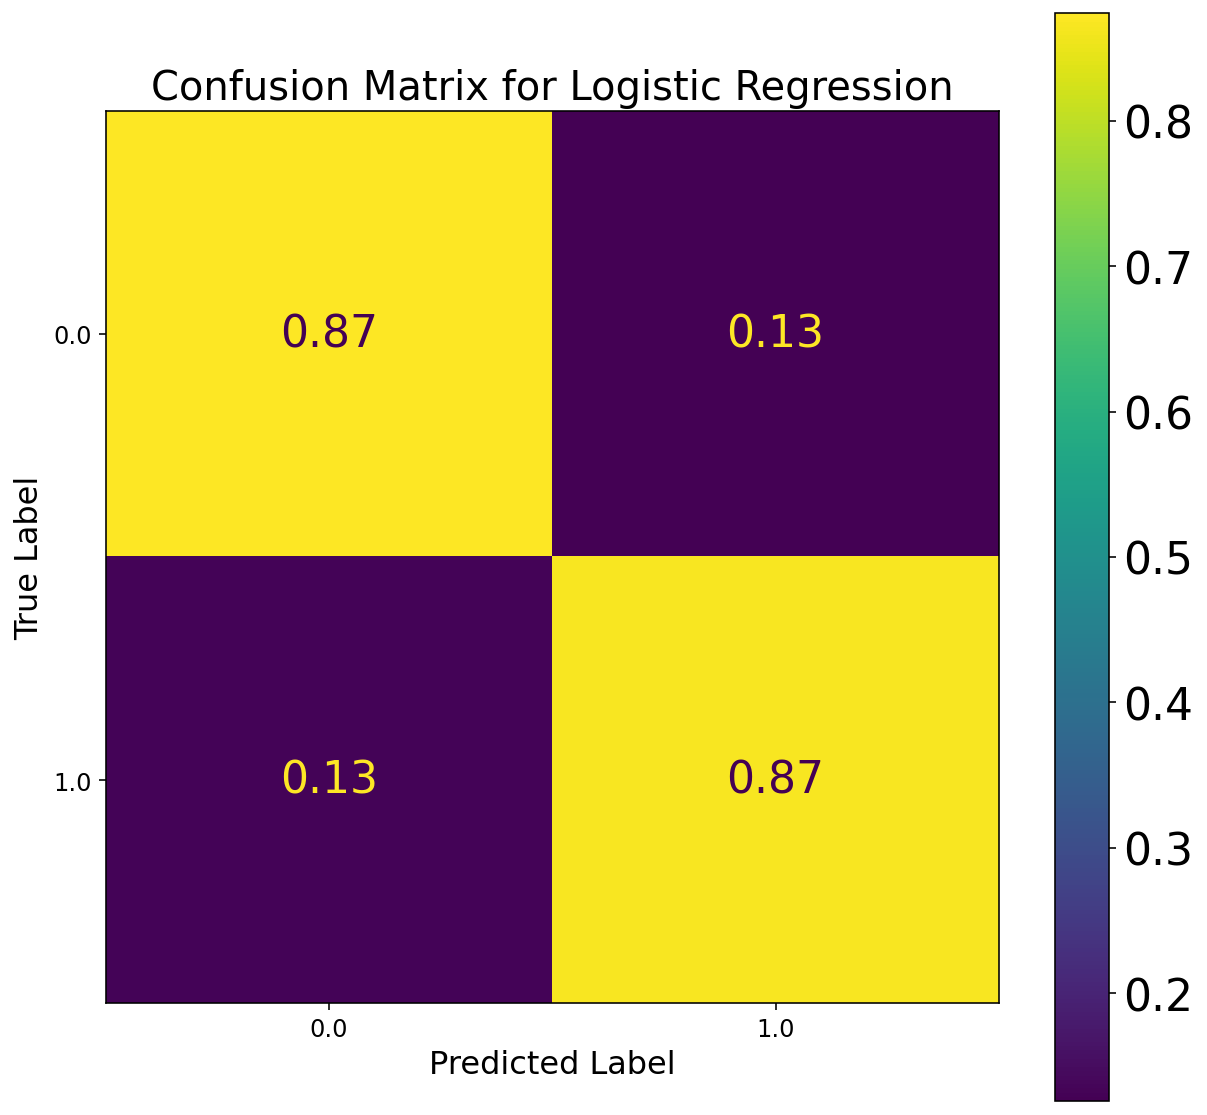

In [79]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.rcParams['font.size'] = 22
plot_confusion_matrix(lr_tfidf, X_test2, y_test2, 
                      values_format='.2f', normalize='true', ax=ax)
plt.title('Confusion Matrix for Logistic Regression', fontsize=20)
plt.xlabel('Predicted Label', fontsize=16)
plt.ylabel('True Label', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig('../assets/cm_lr_tfidf.png', bbox_inches='tight', dpi=220);

The logistic regression model's specificity (i.e. true negative rate) is 87%, meaning that of the posts that were actually from the anxiety subreddit, 87% were correctly classified. 

In [82]:
tn, fp, fn, tp = confusion_matrix(y_test2, # True values.
lr_tfidf.predict(X_test2)).ravel()  # Predicted values.

In [83]:
# What is the test specificity of our model?
spec = tn / (tn + fp)
print(f'Specificity: {round(spec,4)}')

Specificity: 0.8739


In [84]:
# What is the test sensitivity of our model?
sens = tp / (tp + fn)
print(f'Sensitivity: {round(sens,4)}')

Sensitivity: 0.8667


The logistic regression model's sensitivity (i.e. true positive rate) is also 87%, meaning that of the posts that were actually from the ADHD subreddit, 87% were correctly classified. To better visualize this tradeoff between sensitivity and specificity, I will graph the receiver operating characteristic (ROC) curve below.

In [26]:
pred_proba = [i[1] for i in lr_tfidf.predict_proba(X_test2)]

In [27]:
pred_df = pd.DataFrame({'true_values': y_test2, 'pred_probs': pred_proba})

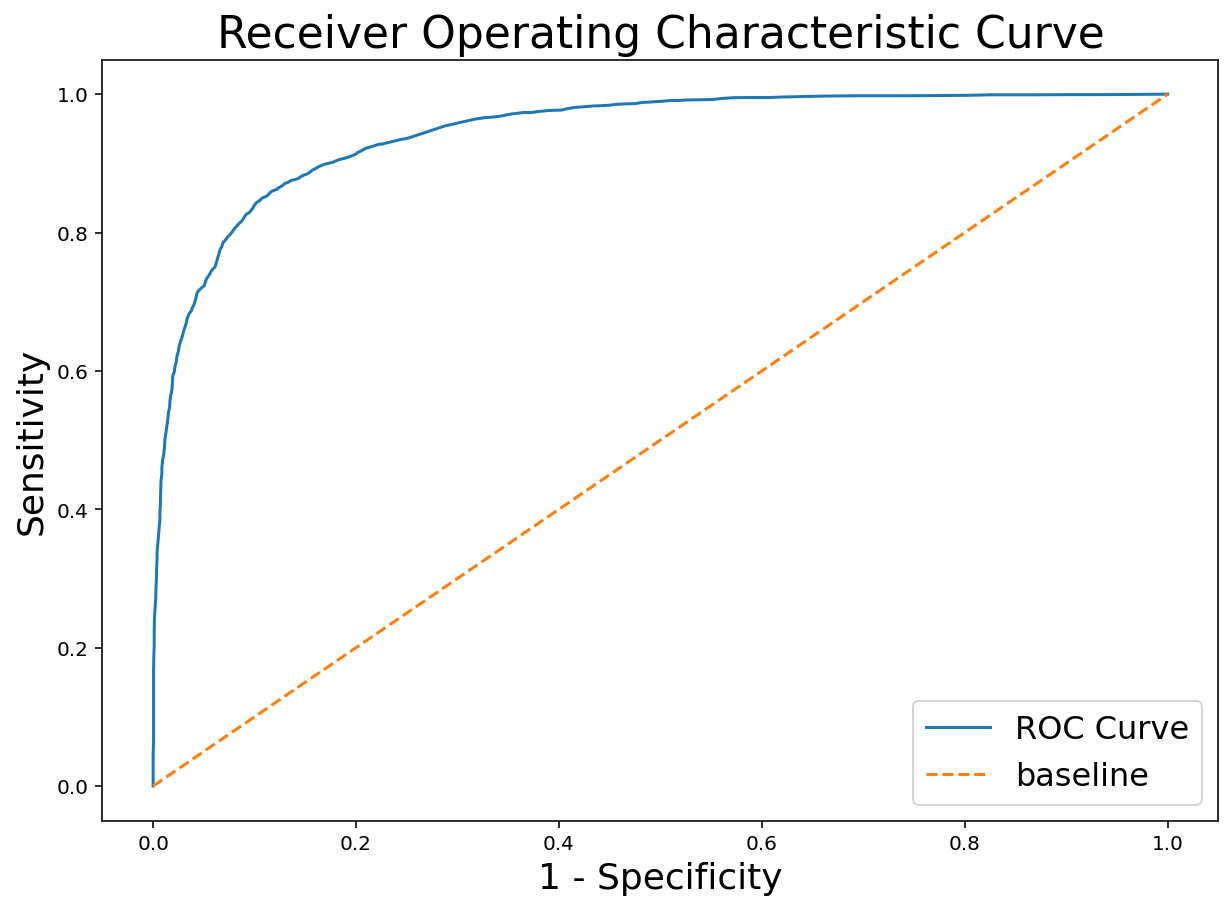

In [28]:
# Create figure.
plt.figure(figsize = (10,7))

# Create threshold values.
thresholds = np.linspace(0, 1, 200)

# Define function to calculate sensitivity. (True positive rate.)
def TPR(df, true_col, pred_prob_col, threshold):
    true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
    false_negative = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
    return true_positive / (true_positive + false_negative)

# Define function to calculate 1 - specificity. (False positive rate.)
def FPR(df, true_col, pred_prob_col, threshold):
    true_negative = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
    false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
    return 1 - (true_negative / (true_negative + false_positive))
    
# Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
tpr_values = [TPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]
fpr_values = [FPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]

# Plot ROC curve.
plt.plot(fpr_values, # False Positive Rate on X-axis
         tpr_values, # True Positive Rate on Y-axis
         label='ROC Curve')

# Plot baseline. (Perfect overlap between the two populations.)
plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         label='baseline',
         linestyle='--')

# Label axes.
plt.title('Receiver Operating Characteristic Curve', fontsize=22)
plt.ylabel('Sensitivity', fontsize=18)
plt.xlabel('1 - Specificity', fontsize=18)

# Create legend.
plt.legend(fontsize=16)

# Save the image
plt.savefig('../assets/AUC_ROC_LogReg.png');

In [29]:
roc_auc_score(pred_df.true_values, pred_df.pred_probs)

0.944389341301248

---

# Random Forests Model using Words

Because the word_df is much larger than the svd_df, running the same GridSearchCV from before was killing my kernel. As such, I will just run one with default parameters (the previous 

In [33]:
rf_word_df = RandomForestClassifier(n_jobs=10)

In [35]:
%%time
rf_word_df.fit(X_train2, y_train2)

CPU times: user 13min 36s, sys: 2.66 s, total: 13min 38s
Wall time: 1min 24s


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=10, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [36]:
rf_word_df.score(X_train2, y_train2)

0.9904676794757223

In [37]:
rf_word_df.score(X_test2, y_test2)

0.8494191242180519

This time the Random Forest Classifier performed a little better on the test set, with the accuracy score going up by about 2 percentage points. Let's see how it performed in terms of sensitivity and specificity.

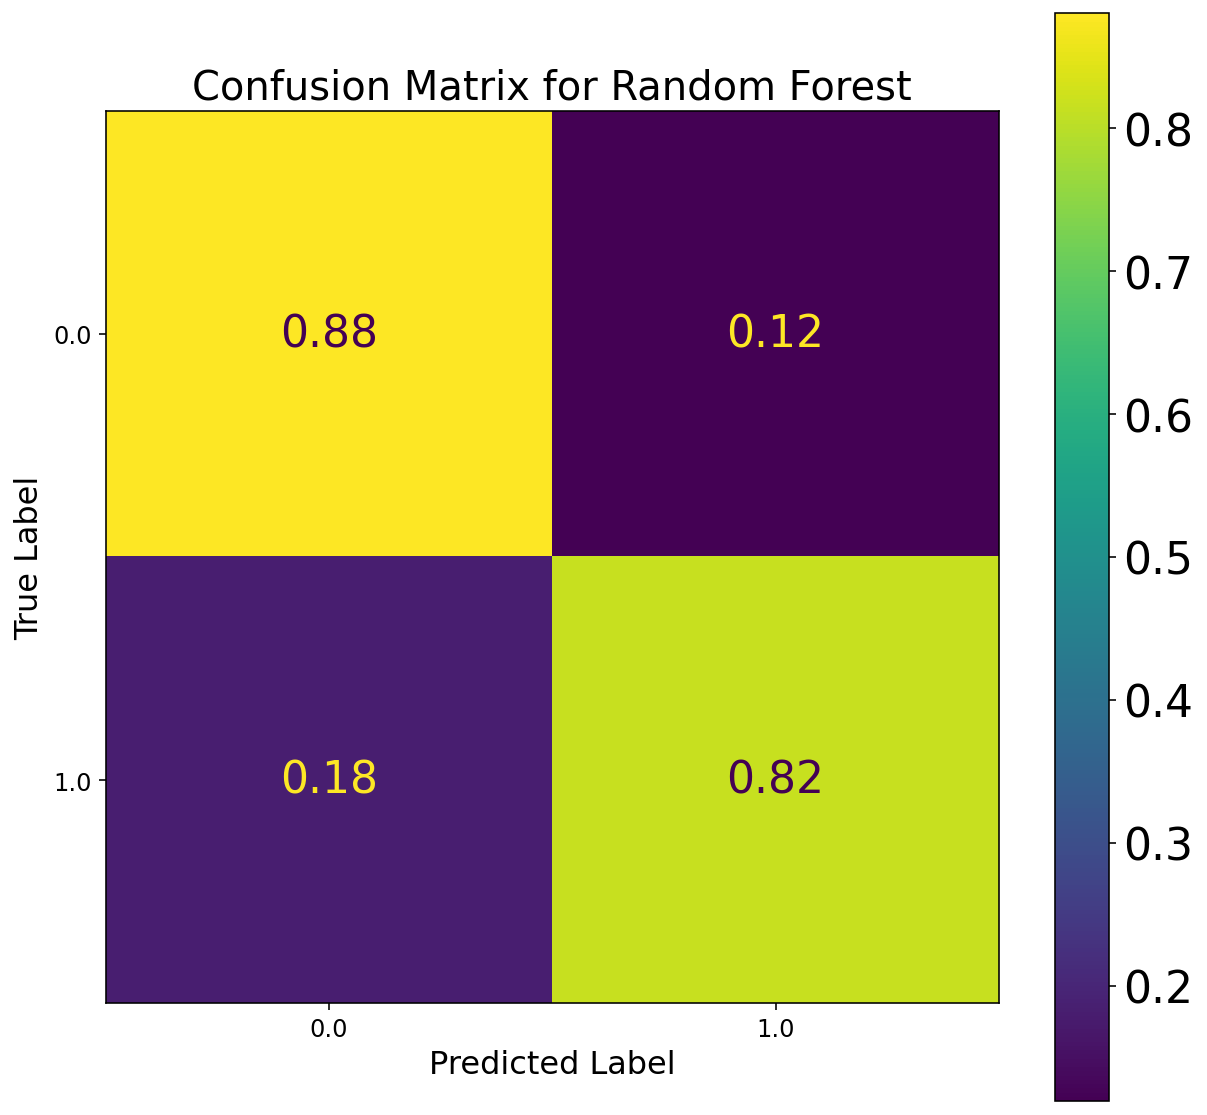

In [75]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.rcParams['font.size'] = 22
plot_confusion_matrix(rf_word_df, X_test2, y_test2, 
                      values_format='.2f', normalize='true', ax=ax)
plt.title('Confusion Matrix for Random Forest', fontsize=20)
plt.xlabel('Predicted Label', fontsize=16)
plt.ylabel('True Label', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig('../assets/cm_rf.png');

The random forests model's specificity was 88%, slightly higher than the logistic regression model. 

However, the sensitivity this time was much lower, at only 82%

In [44]:
feat_importance = pd.DataFrame(rf_word_df.feature_importances_, word_df.columns, columns=['importance'])

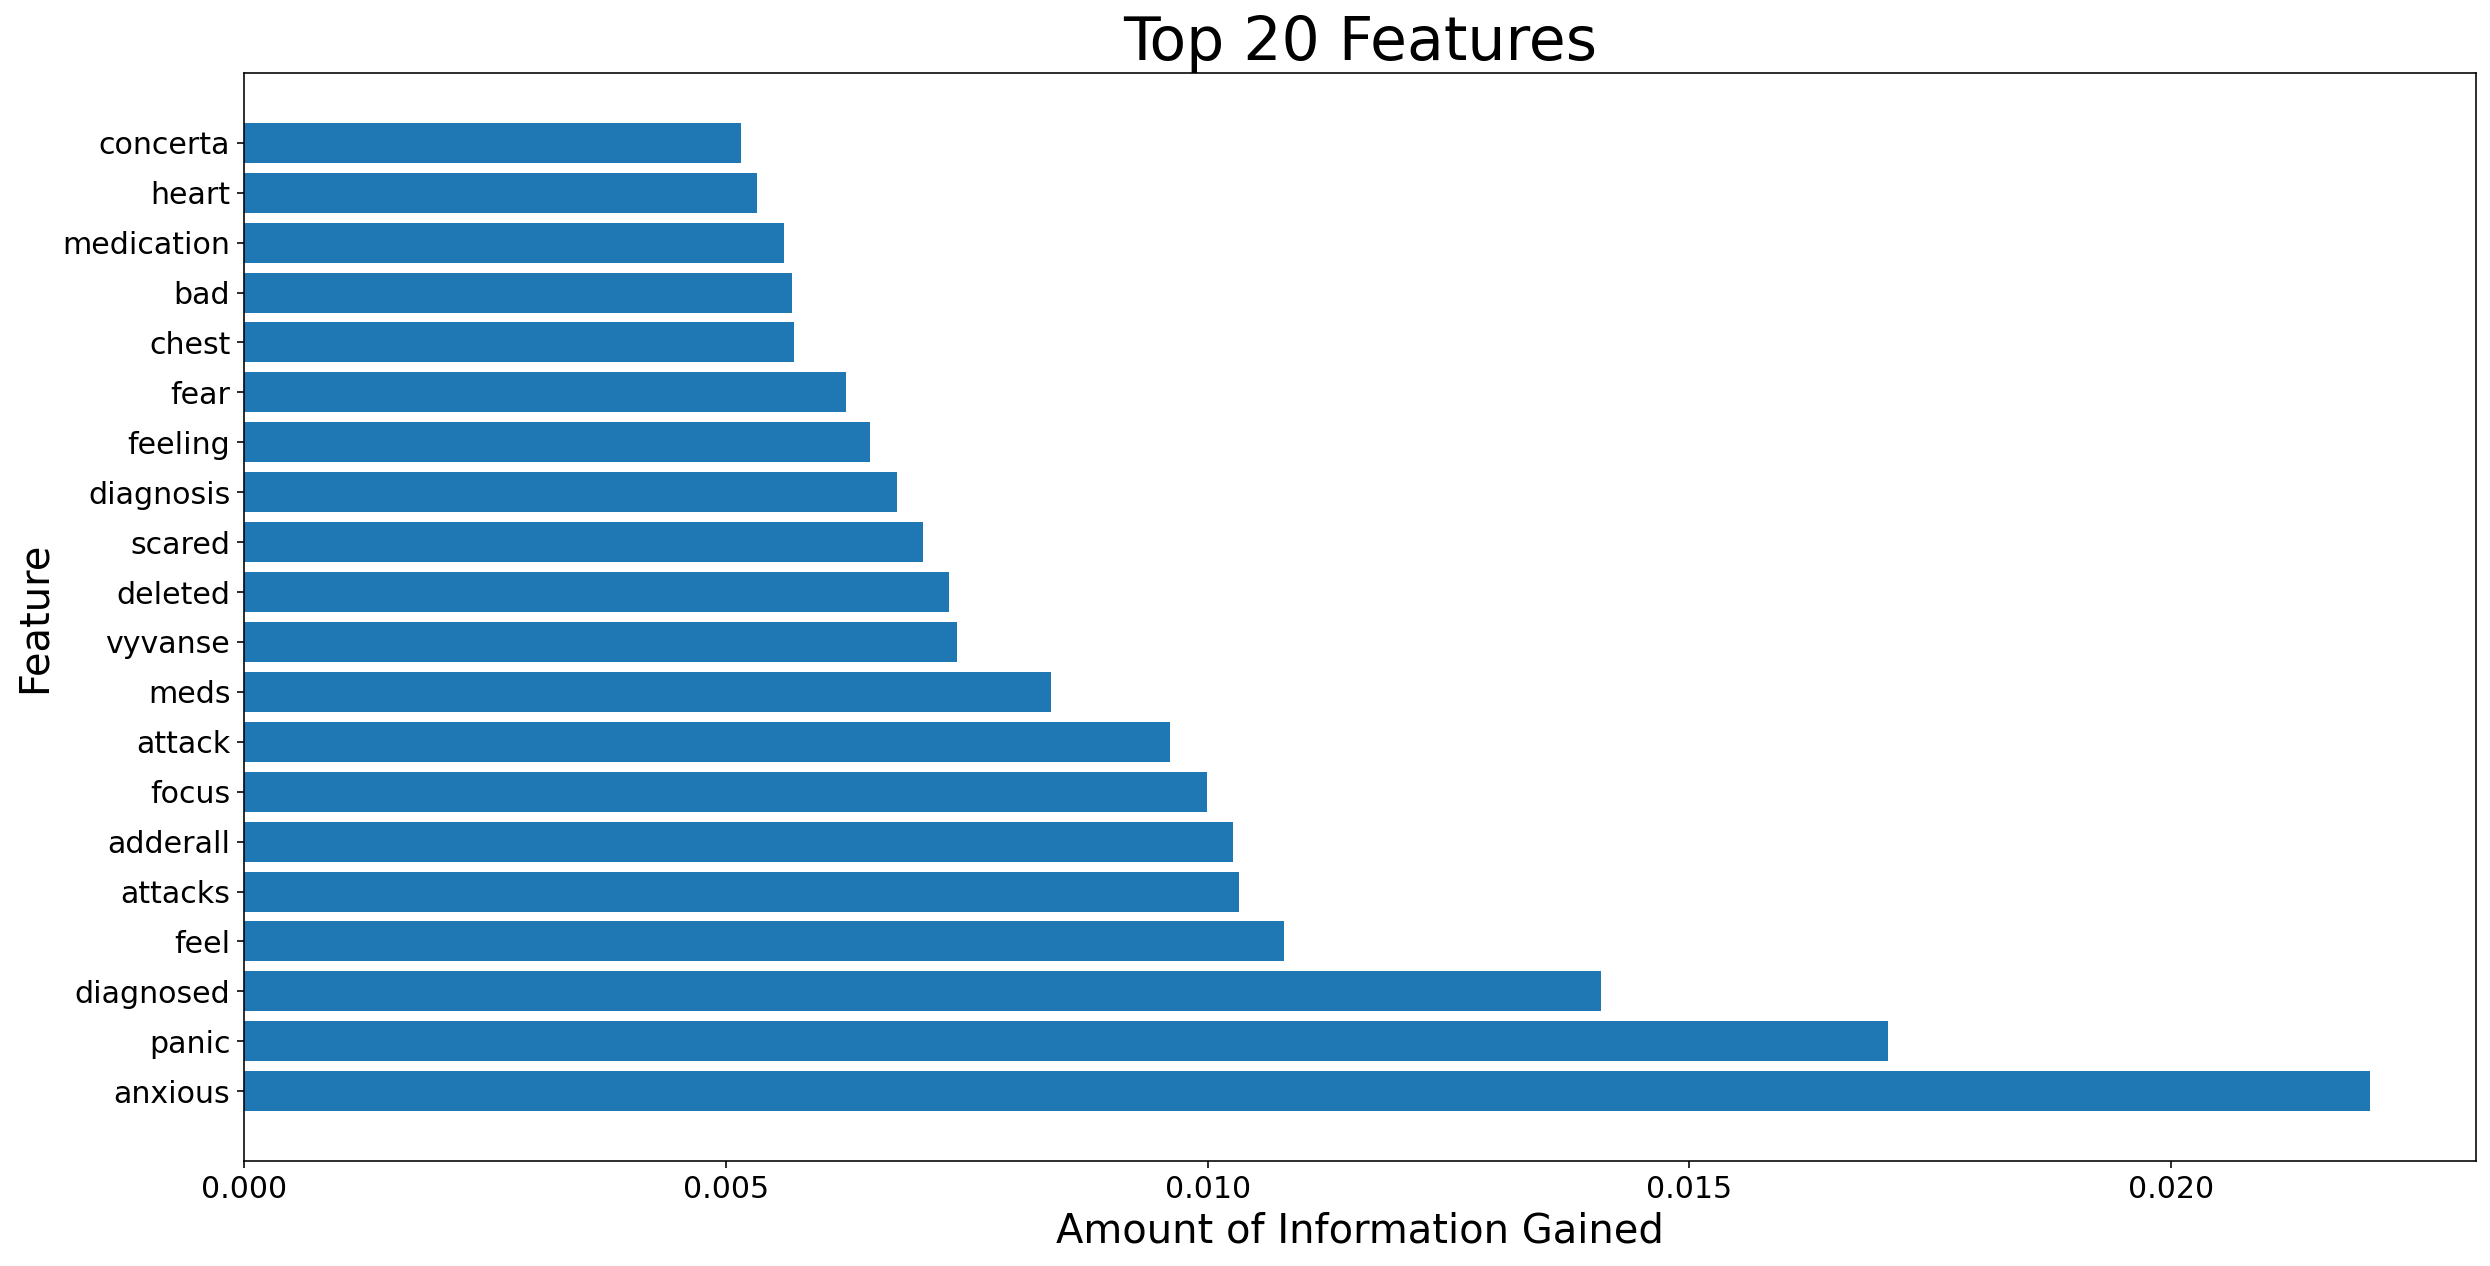

In [76]:
plt.figure(figsize=(20,10))
temp = feat_importance.sort_values('importance', ascending=False).head(20)
plt.barh(temp.index, temp['importance'])
plt.title("Top 20 Features", fontsize=30)
plt.xlabel('Amount of Information Gained', fontsize=20)
plt.ylabel('Feature', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.savefig('../assets/top20feats.png');

Here we can see that anxious, panic, and diagnosed are the top 3 important features in our random forest model. This is interesting, because these were not the words we focused on during the EDA process (i.e. deleted here is only the 11th most important word). However, the rest of the words are those we expect, such as those related to medication and emotions. 

In [47]:
pred_proba = [i[1] for i in rf_word_df.predict_proba(X_test2)]

In [48]:
pred_df = pd.DataFrame({'true_values': y_test2, 'pred_probs': pred_proba})

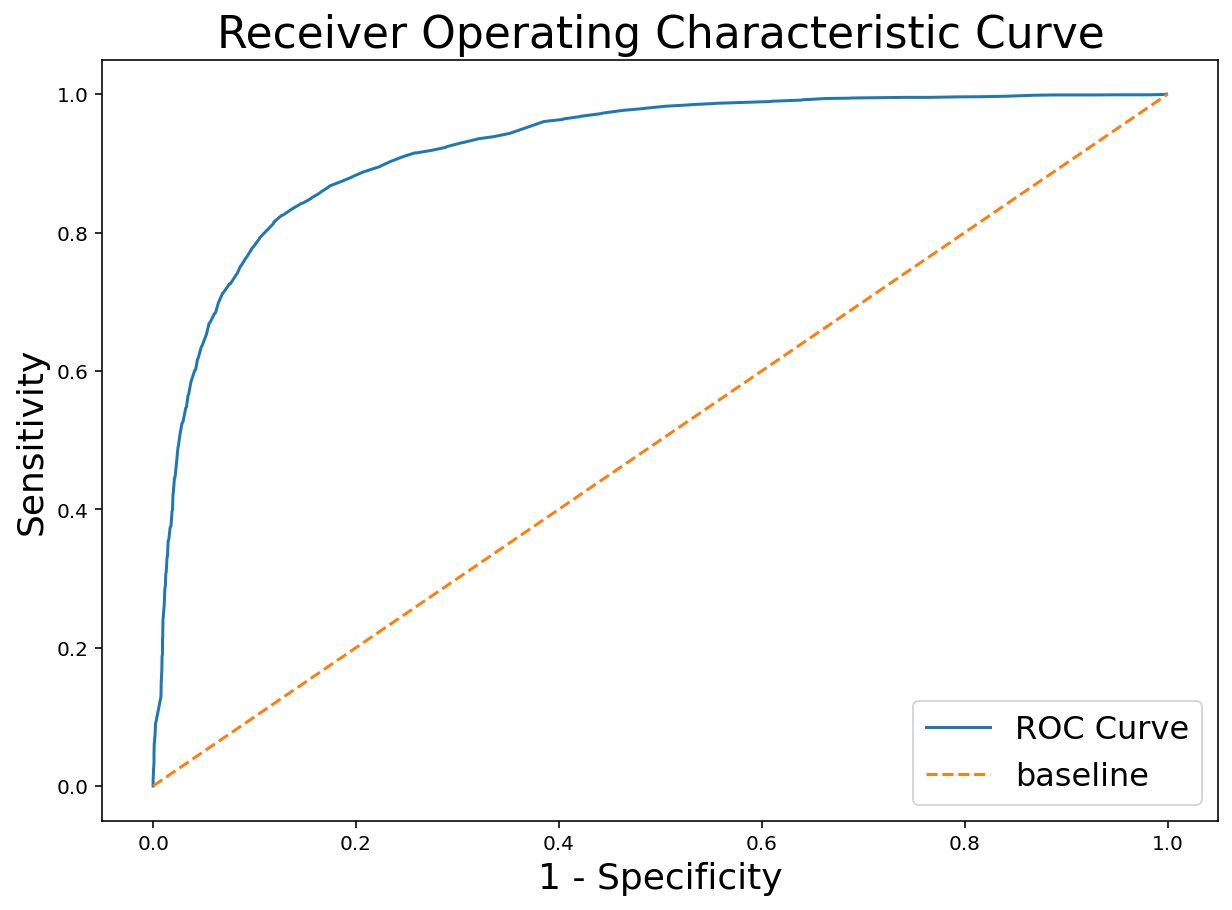

In [50]:
# Create figure.
plt.figure(figsize = (10,7))

# Create threshold values.
thresholds = np.linspace(0, 1, 200)

# Define function to calculate sensitivity. (True positive rate.)
def TPR(df, true_col, pred_prob_col, threshold):
    true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
    false_negative = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
    return true_positive / (true_positive + false_negative)

# Define function to calculate 1 - specificity. (False positive rate.)
def FPR(df, true_col, pred_prob_col, threshold):
    true_negative = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
    false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
    return 1 - (true_negative / (true_negative + false_positive))
    
# Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
tpr_values = [TPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]
fpr_values = [FPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]

# Plot ROC curve.
plt.plot(fpr_values, # False Positive Rate on X-axis
         tpr_values, # True Positive Rate on Y-axis
         label='ROC Curve')

# Plot baseline. (Perfect overlap between the two populations.)
plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         label='baseline',
         linestyle='--')

# Label axes.
plt.title('Receiver Operating Characteristic Curve', fontsize=22)
plt.ylabel('Sensitivity', fontsize=18)
plt.xlabel('1 - Specificity', fontsize=18)

# Create legend.
plt.legend(fontsize=16)

# Save the image
plt.savefig('../assets/AUC_ROC_RF.png');

In [51]:
roc_auc_score(pred_df.true_values, pred_df.pred_probs)

0.9211736982832283

As we can see, the ROC-AUC score is lower than the logistic regression model, so if I had to choose 1 model for a final "production" model, I would choose the logistic regression model that uses the full vectorized word matrix. 